In [146]:
from k_means import seq2dict, levelorderTraversal, lcs_distance
import re, os
import numpy as np
from collections import Counter
import string
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme(style="ticks")

train_source = "data/para/train/paranmt-h2/4cr_qpbo_sentences-level3.source"
test_source = "data/para/test/paranmt-h2/carb_sentences-level3.source"
test_para = "data/para/test/paranmt-h2/carb_sentences-level3.tgt"

CENTERS=[
    [0, 1, 8, 12, 8, 12, 2, 4, 16, 9, 2, 9, 2, 29, 5, 57, 2, 58], 
    [0, 1, 2, 4, 16, 10, 11, 5, 27, 4],
    [0, 1, 1, 12, 1, 12, 1, 12, 17, 1, 16, 2, 4, 2, 4, 2, 4, 2, 4],
    [0, 1, 1, 12, 2, 4, 16, 2, 4, 2, 12, 2, 12, 5, 2],
    [0, 1, 2, 4, 16, 2, 4, 38, 2],
    [0, 1, 2, 4, 16, 10, 3, 3, 3, 3, 3, 5, 4],
]

In [149]:
# Stat words && syntactics
train_counter = Counter()
test_counter = Counter()
train_syns, test_syns = [], []

train_test_lines = []
with open(train_source, "r") as f1:
    train_test_lines.append(f1.readlines())
with open(test_source, "r") as f2:
    train_test_lines.append(f2.readlines())

for i, lines in enumerate(train_test_lines):
    for line in lines:
        items = line.split(' <sep> ')
        if len(items) >= 2:
            sent = items[0].strip()
            pure_sent = sent.translate(str.maketrans('', '', string.punctuation))
            parseTree = items[1].strip()
            # words
            if i==0:
                train_counter.update(pure_sent.split())
                train_syns.append(parseTree)
            else:
                test_counter.update(pure_sent.split())
                test_syns.append(parseTree)
print(f"# of train samples: {len(train_syns)}")
print(f"# of test samples: {len(test_syns)}")

# of train samples: 589941
# of test samples: 3937


In [152]:
# Stat CaRB-AutoPara
test_para_counter = Counter()
with open(test_para, "r") as f:
    for line in f:
        pure_sent = line.strip().translate(str.maketrans('', '', string.punctuation))
        test_para_counter.update(pure_sent.split())
print(len(test_para_counter))

5120


In [153]:
# Calculate words distributions with bag-of-words for Train && CaRB
train_total = sum(train_counter.values())
test_total = sum(test_counter.values())
test_bag = [(w, f/test_total) for w,f in sorted(test_counter.items(), key=lambda x:x[1], reverse=True)]
train_carb_bag = []
new_test_bag = []
for i in range(len(test_bag)):
    w,f = test_bag[i]
    if w in train_counter:
        new_test_bag.append((w, f))
        train_carb_bag.append((w, train_counter[w] / train_total))
test_carb_bag = new_test_bag
print(train_carb_bag[:3])
print(test_carb_bag[:3])

[('the', 0.06742178237311247), ('of', 0.04360020414375318), ('and', 0.010825012563444581)]
[('the', 0.05944359666627538), ('of', 0.03190515318699378), ('and', 0.02530813475760066)]


In [155]:
# Calculate words distributions with bag-of-words for Train && CaRB-AutoPara
train_total = sum(train_counter.values())
test_para_total = sum(test_para_counter.values())
test_para_bag = [(w, f/test_total) for w,f in sorted(test_counter.items(), key=lambda x:x[1], reverse=True)]
train_para_bag = []
new_test_bag = []
for i in range(len(test_bag)):
    w,f = test_bag[i]
    if w in train_counter:
        new_test_bag.append((w, f))
        train_para_bag.append((w, train_counter[w] / train_total))
test_para_bag = new_test_bag
print(train_para_bag[:3])
print(test_bag[:3])

[('the', 0.06742178237311247), ('of', 0.04360020414375318), ('and', 0.010825012563444581)]
[('the', 0.05944359666627538), ('of', 0.03190515318699378), ('and', 0.02530813475760066)]


In [156]:
# Calculate syntactic distances for partial samples
np.random.seed(7119)
n_sample = 300
train_samples_syns = np.random.choice(train_syns, n_sample, replace=False)
test_samples_syns = np.random.choice(test_syns, n_sample, replace=False)
distances = np.zeros((len(CENTERS), n_sample))

# for i in tqdm(range(n_sample)):
#     for j in range(i+1, n_sample):
#         root_train = seq2dict(train_samples_syns[i][1:-1], 4)
#         seq_train = []
#         levelorderTraversal(root_train, seq_train)
#         root_test = seq2dict(test_samples_syns[j][1:-1], 4)
#         seq_test = []
#         levelorderTraversal(root_test, seq_test)
#         distance = lcs_distance(seq_train[1:], seq_test[1:], weight_decay=0.95)
#         distances[i,j] = distance
#         distances[j,i] = distance
for i in tqdm(range(len(CENTERS))):
    for j in range(n_sample):
        root_train = seq2dict(train_samples_syns[j][1:-1], 4)
        seq_train = []
        levelorderTraversal(root_train, seq_train)
        distance = lcs_distance(seq_train[1:], CENTERS[i][1:], weight_decay=0.95)
        distances[i,j] = distance

100%|██████████| 6/6 [00:00<00:00, 21.29it/s]


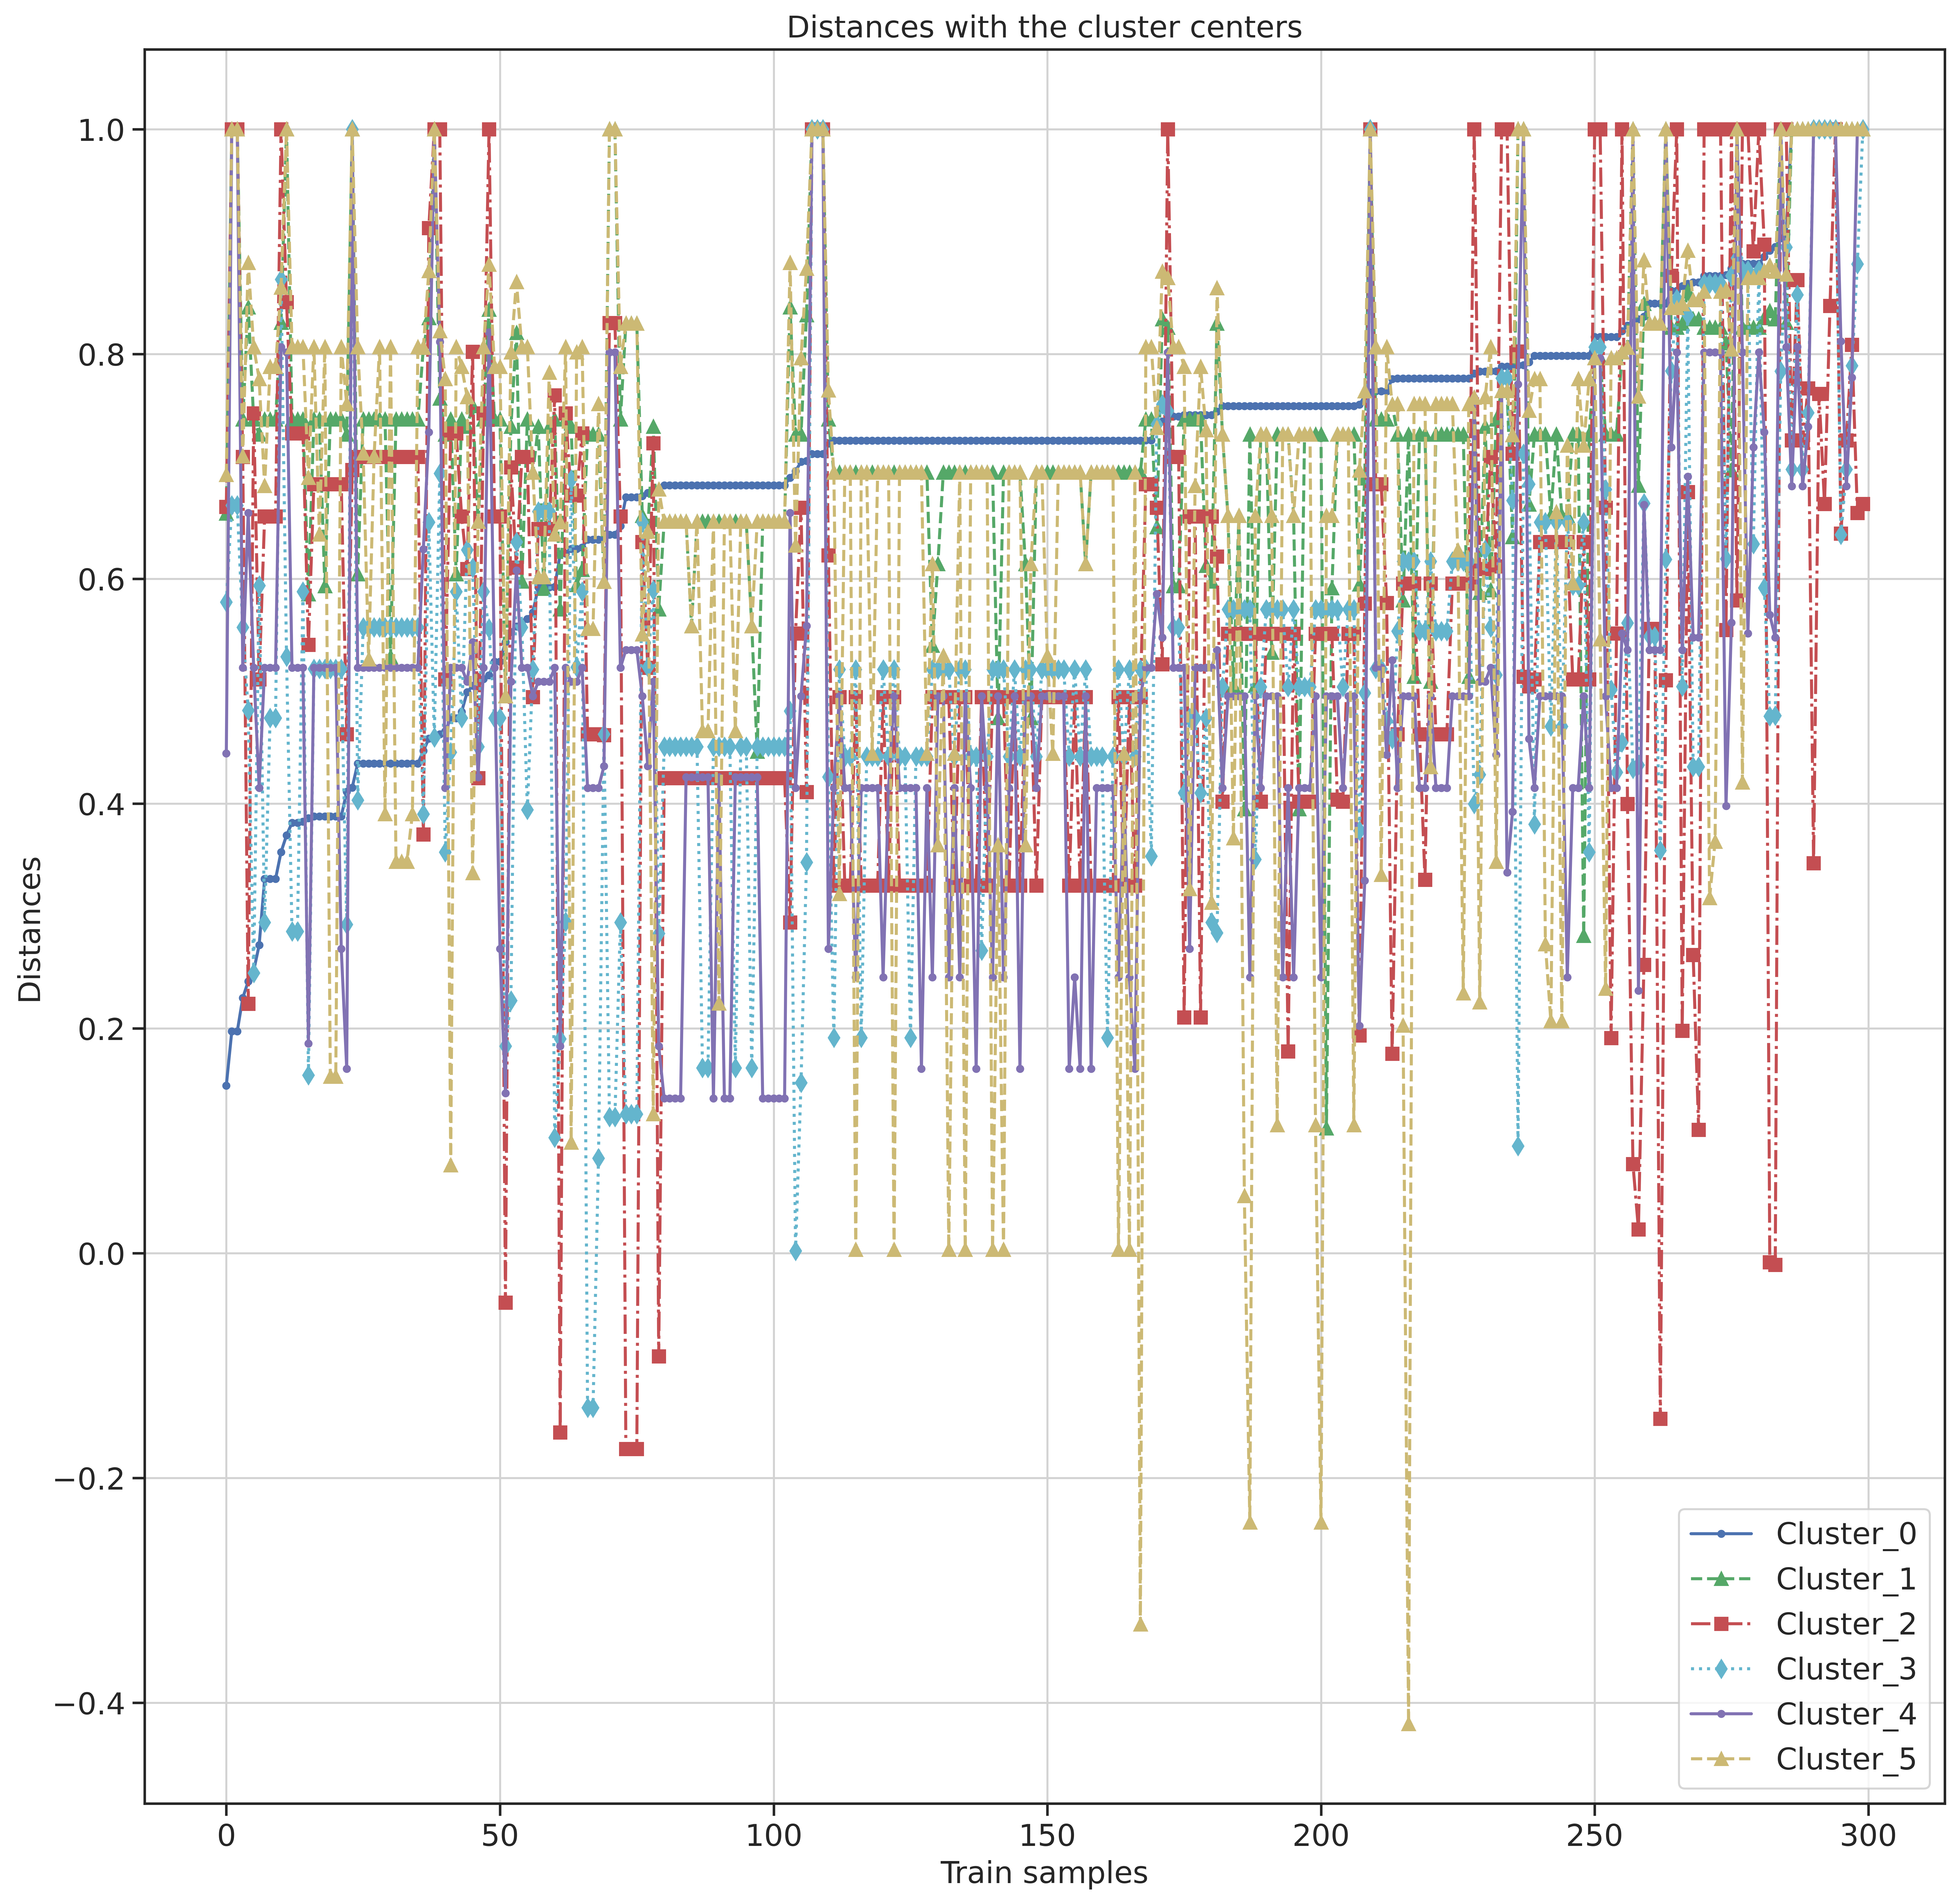

In [162]:
# Plot distances
sort_ids = np.argsort(distances[0])
for i in range(len(distances)):
    distances[i] = distances[i][sort_ids]

fig, axes = plt.subplots(1, 1, figsize=(16,16), dpi=500)
# fig, axes = plt.subplots(1, 1, figsize=(25,25), dpi=500)
all_colors = ['b','g','r','c','m','y','k','w']
linestyles=["-","--","-.",":"]
markers=[".","^","s", "d"]
# plot line chars for each sample
for i in range(len(distances)):
    X = list(range(len(distances[0])))
    cl = all_colors[i%8]
    label = f"Cluster_{i}"
    mk = markers[i%len(markers)]
    ls = linestyles[i%len(linestyles)]
    axes.plot(X, distances[i], linestyle=ls, color=cl, marker=mk, linewidth=1.5, label=label)
    # annotate each data point
    if False:
        for x_, y_ in zip(X, distances[i]):
            axes.text(x_, y_, y_, ha='left', va='bottom')
# set title
axes.set_title("Distances with the cluster centers", fontsize=15)
# set minimal intervals
# axes.xaxis.set_minor_locator(MultipleLocator(x_minor_locator))
# axes.yaxis.set_minor_locator(MultipleLocator(y_minor_locator))
# grid line
axes.grid(which='both', c='lightgrey')
# set labels of axis
axes.set_xlabel("Train samples", fontsize=15)
axes.set_ylabel("Distances", fontsize=15)
# set ticks
# axes.set_xticks(xticks)
# axes.set_yticks(yticks)
for xlabel in axes.xaxis.get_ticklabels():
    xlabel.set_fontsize(15)
for ylabel in axes.yaxis.get_ticklabels():
    ylabel.set_fontsize(15)
plt.legend(loc="lower right", fontsize=15)
# save
fig.savefig("{}.png".format("distances"), bbox_inches='tight')
plt.show()

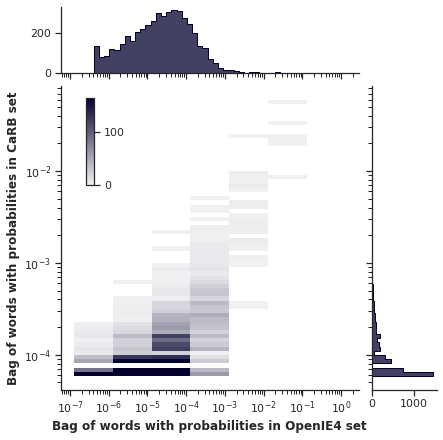

In [159]:
# Plot words joint distribution for Train && CaRB
X = [v[1] for v in train_carb_bag]
Y = [v[1] for v in test_carb_bag]
g = sns.JointGrid(x=X, y=Y, marginal_ticks=True, ratio=4)

# Set a log scaling on the y axis
g.ax_joint.set(yscale="log")
g.ax_joint.set(xscale="log")

# Create an inset legend for the histogram colorbar
cax = g.figure.add_axes([.15, .55, .02, .2])

# Add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.5, cbar=True, cbar_ax=cax,
)
g.plot_marginals(sns.histplot, element="step", color="#03012d")

# plt.title("Words joint distribution", x=16, y=-2.9)
g.ax_joint.set_xlabel('Bag of words with probabilities in OpenIE4 set', fontweight='bold')
g.ax_joint.set_ylabel('Bag of words with probabilities in CaRB set', fontweight='bold')
# plt.savefig("words_distribution.png")
g.savefig("words_distribution_train_carb.png", dpi=500)

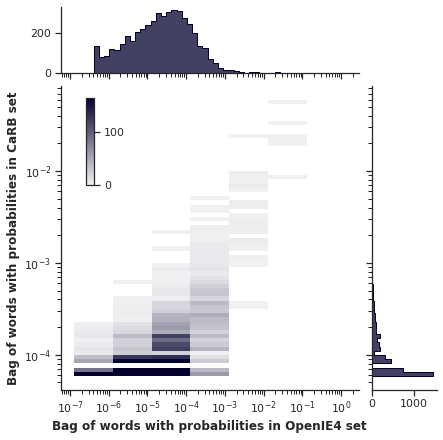

In [161]:
# Plot words joint distribution for Train && CaRB-AutoPara
X = [v[1] for v in train_para_bag]
Y = [v[1] for v in test_para_bag]
g = sns.JointGrid(x=X, y=Y, marginal_ticks=True, ratio=4)

# Set a log scaling on the y axis
g.ax_joint.set(yscale="log")
g.ax_joint.set(xscale="log")

# Create an inset legend for the histogram colorbar
cax = g.figure.add_axes([.15, .55, .02, .2])

# Add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.5, cbar=True, cbar_ax=cax,
)
g.plot_marginals(sns.histplot, element="step", color="#03012d")

# plt.title("Words joint distribution", x=16, y=-2.9)
g.ax_joint.set_xlabel('Bag of words with probabilities in OpenIE4 set', fontweight='bold')
g.ax_joint.set_ylabel('Bag of words with probabilities in CaRB set', fontweight='bold')
# plt.savefig("words_distribution.png")
g.savefig("words_distribution_train_carb_para.png", dpi=500)